In [1]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed
import pandas as pd
import sys
import os
import seaborn as sns 
from sklearn.metrics import r2_score
import math
import matplotlib as mpl
from tqdm import tqdm
from matplotlib.lines import Line2D

from cryptic_rnn import *

# Functions

In [6]:
def run_exp(cue_dict, j):

    all_syms = list(cue_dict.keys())
    all_input_vals = list(np.arange(2,18))
    input_vals = random.sample(all_input_vals,num_inputs)
    input_vals.sort() # sort values (so A is smallest)
    # randomly select values for each input
    for i, s in enumerate(all_syms):
        cue_dict[s] = input_vals[i]
    
    trial_list = []
    for s in range(1, len(all_syms)+1):
        trial_list += (generate_pairs(ops, all_syms, cue_dict, s))
    
    primitives = generate_pos_primitives(all_syms, cue_dict)
    balanced_prims = generate_complex_primitives(ops, all_syms, cue_dict)
    train_trials = [trial for trial in trial_list if trial not in balanced_prims]
    
    basic_train = train_trials[:j]
    trainseqs_b = basic_train + balanced_prims
    trainseqs_p = basic_train + primitives
    testseqs = generate_pos_trials(ops, all_syms, all_syms, cue_dict)
    testseqs = [t for t in testseqs if t not in trainseqs_b]

    # load data for primitive training
    testseqs = change_dict(testseqs, cue_dict)
    test_inputs = convert_seq2inputs(testseqs, num_classes=num_classes, seq_len=5)
    testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)

    tseqs = change_dict(trainseqs_b, cue_dict)
    train_inputs = convert_seq2inputs(tseqs, num_classes=num_classes, seq_len=5)
    trainset_b = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
    
    tseqs = change_dict(trainseqs_p, cue_dict)
    train_inputs = convert_seq2inputs(tseqs, num_classes=num_classes, seq_len=5)
    trainset_p = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
        
    # run primitive training RNN
    model_b = OneStepRNN(input_size, output_size, hidden_size, num_layers, xavier_gain)
    model_p = copy.deepcopy(model_b)
    criterion = nn.MSELoss()
    
    optimizer = torch.optim.Adam(model_b.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model_b,optimizer,criterion, trainset_b, [trainset_b, testset], epochs, hidden_size)
        
    optimizer = torch.optim.Adam(model_p.parameters(), lr=learningRate)
    loss2, acc2 = run_acc(model_p,optimizer,criterion, trainset_p, [trainset_p, testset], epochs, hidden_size)
    
       
    return {'cue_dict':cue_dict,'test': testset,
           'loss_b':loss1, 'acc_b':acc1, 'mod_b': model_b,\
           'loss_p':loss2, 'acc_p':acc2, 'mod_p': model_p}

def run_plot(cue_dict, j):
    
    t1 = time.time()
    res  = Parallel(n_jobs = -1)(delayed(run_exp)(cue_dict, j) for i in tqdm(range(num_sims)))
    t2 = time.time()
    print('run time: ', (t2-t1)/60)
    
    tests = [r['test'] for r in res]
    cue_dicts = [r['cue_dict'] for r in res]
    
    losses_b = np.hstack([r['loss_b'] for r in res])
    acc_train_b = np.array([r['acc_b'][:,0] for r in res]).T
    acc_test_b = np.array([r['acc_b'][:,1] for r in res]).T
    mods_b = [r['mod_b'] for r in res]

    losses_p = np.hstack([r['loss_p'] for r in res])
    acc_train_p = np.array([r['acc_p'][:,0] for r in res]).T
    acc_test_p = np.array([r['acc_p'][:,1] for r in res]).T
    mods_p = [r['mod_p'] for r in res]

    r2_b, dfs_b, _ = predcorr(mods_b, tests, hidden_size, plot_corr =False)
    r2_p, dfs_p, _ = predcorr(mods_p, tests, hidden_size, plot_corr = False)

    print('B: ', r2_b)
    print('P: ', r2_p)
    
    acc_df = pd.DataFrame({'acc_train_b': acc_train_b[-1,:], 'acc_test_b': acc_test_b[-1,:],\
                           'acc_train_p': acc_test_p[-1,:], 'acc_test_p': acc_test_p[-1,:]})
    
    return {'mods_b':mods_b, 'mods_p':mods_p, \
            'res':res, 'tests': tests, 'cue_dicts': cue_dicts, 'acc_df':acc_df }

def input_frac_run(num_inputs, max_train_trials):
    
    all_syms = total_syms[:num_inputs]
    input_vals = random.sample(all_input_vals,num_inputs)
    # randomly select values for each input
    cue_dict = {}
    for i, s in enumerate(all_syms):
        cue_dict[s] = input_vals[i]
    
    reses = []
    for j in range(1, max_train_trials+1):
        print('##################\nnumber of train trials: ',j)      
        res_j = run_plot(cue_dict, j)
        reses.append(res_j)      
    
    return reses


def extract_loss(res):
    losses_b = np.hstack([r['loss_b'] for r in res])
    losses_p = np.hstack([r['loss_p'] for r in res])
    return {'losses_b':losses_b,'losses_p':losses_p}

def extract_r2(res):
    tests = [r['test'] for r in res]
    mods_b = [r['mod_b'] for r in res]
    mods_p = [r['mod_p'] for r in res]

    r2_b, dfs_b, _ = predcorr(mods_b, tests, hidden_size, plot_corr =True)
    r2_p, dfs_p, _ = predcorr(mods_p, tests, hidden_size, plot_corr = True)
    
def generate_pairs(op, inputs, cue_dict, shift):
    seq = []
    inputs1 = inputs.copy()
    inputs2 = inputs.copy()
    for s in range(shift):
        inputs2.append(inputs2.pop(0))
    for i in range(len(inputs1)):
        trial = [(op, inputs1[i]), (op, inputs2[i]), '=']
        trial.append(calculate_output(trial, cue_dict))
        seq.append(trial)
    return seq


def extract_r2(res):
    """ calculates mean and std R^2 for model predictions-ground truth correlation for model set of 
        each training regime
        Args: results dictionary
        Returns, mean R^2 and std for balanced and primitive regime"""
    tests = res['tests']
    mods_b = res['mods_b']
    mods_p = res['mods_p']
    r2_b, sterr_b = get_r2s(mods_b, tests, hidden_size)
    r2_p, sterr_p = get_r2s(mods_p, tests, hidden_size)
    
    return [r2_b, r2_p, sterr_b, sterr_p]
    
def get_r2s(mods, tests, hidden_size=20):
    """ calculates mean R^2 and std for list of models and test sequences """
    N = len(mods)
    r2s = []
    for i in range(len(mods)):
        df = test_preds(mods[i], [tests[i]], hidden_size)
        r2s.append(r2_score(df['pred'], df['label'])) # individual model r2 score
    r2_mean = np.mean(r2s)
    r2_sterr = np.std(r2s)/math.sqrt(N)
    
    return r2_mean, r2_sterr




In [46]:
## plotting
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## RNN params

In [3]:
# data
num_classes = 22
batchsize=1

# RNN specs
input_size = num_classes
output_size = 1
num_layers = 1
hidden_size = 20
learningRate = 0.005
xavier_gain = 0.0001

## running params
epochs = 1000
num_sims = 100

## Sequences

In [4]:
ops = '+'

num_inputs = 4
total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)
# randomly select values for each input
cue_dict = {}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]  
print('cue_dict ',cue_dict)

cue_dict  {'A': 14, 'B': 10, 'C': 6, 'D': 7}


In [29]:
num_sims= 200
epochs = 1000
res = input_frac_run(4, 8)

In [30]:
vals = np.empty((0,4))
for i, res_set in enumerate(res):
    set_vals = np.array(extract_r2(res_set)).reshape(-1,4)
    vals = np.vstack([vals, set_vals])

Text(0.5, 0.98, '$R^2$ score against number of training trails')

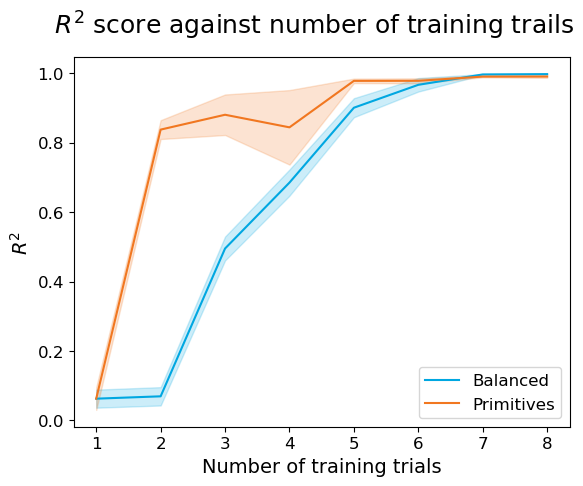

In [49]:
j = 0
labels = ['Balanced','Primitives']
colors = ['#00A7E1', '#F17720']

xpos = np.arange(1, vals.shape[0]+1)
Nn = int(vals.shape[1]/2)
for j in range(Nn):
    plt.plot(xpos, vals[:,j], label = labels[j], color=colors[j])
    plt.fill_between(xpos, vals[:,j] + vals[:,j+Nn], vals[:,j] - vals[:,j+Nn], color=colors[j], alpha=0.2)
plt.legend(loc='lower right')
plt.xlabel('Number of training trials')
plt.ylabel('$R^2$')
plt.suptitle('$R^2$ score against number of training trails')

In [26]:
savedir = '../results/fraction_inputs/4_inputs'
with open(savedir, 'wb') as f:
    pickle.dump(res, f)
f.close()

In [52]:
res[0].keys()

dict_keys(['mods_b', 'mods_p', 'res', 'tests', 'cue_dicts', 'acc_df'])

In [53]:
i = 1
len(res)

8

In [56]:
res[0]['acc_df']['acc_train_b'].mean()

1.0

In [57]:
res[0]['acc_df']['acc_train_p'].mean()

0.1776923076923077